In [1]:
!sudo pip install shap

     |████████████████████████████████| 327kB 5.6MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463906 sha256=c76f45793f08950448a2c2dc04c1743933d92efc4426c0a79c1bb6ed14e81bbb
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [2]:
!sudo pip install catboost

     |████████████████████████████████| 66.3MB 59kB/s 


In [3]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import shap
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import KFold,cross_val_predict
from sklearn.metrics import mean_absolute_error as mse 
# Machine Learning Models
from sklearn.linear_model import LinearRegression,Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,ExtraTreesRegressor,AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor as BlueCat

# Statistical Models
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# #Diable the warnings
import warnings
warnings.filterwarnings('ignore')

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.set(style='whitegrid')
pd.set_option('precision',3)

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [4]:
lst_stck = ['MSFT', 'IBM', 'AAPL','GOOGL']   # List of Stocks
lst_curr = ['DEXJPUS', 'DEXUSUK']  # List of Currency Exchanges
lst_indx = ['SP500', 'DJIA', 'VIXCLS'] # List of Indices
lst_AAPL = ['AAPL_DT','AAPL_3DT','AAPL_6DT','AAPL_12DT']

# we might need to split feature lists
def splt_lst(llst):
    return llst[:len(llst)//2], llst[len(llst)//2:]

t1 = '20/12/2010'
# Load dataset from online
stck_id = web.DataReader(lst_stck, 'yahoo',start=t1)
curr_id = web.DataReader(lst_curr, 'fred',start=t1)
indx_id = web.DataReader(lst_indx, 'fred',start=t1)

In [5]:
dt = 5 # can be any number

# target variable (lagged 5 day [.shift(-5)] + 5-bus.day. returns: (.diff(5))")
Y = np.log(stck_id.loc[:, ('Adj Close', 'AAPL')]).diff(dt).shift(-dt)
Y.name = 'AAPL_Pred'

# 1. log of stock  (5 bus.day return)
X1 = np.log(stck_id.loc[:, ('Adj Close', ('GOOGL','IBM','MSFT'))]).diff(dt)
X1.columns = X1.columns.droplevel() # remove adj close index

# 2 & 3. log of currency & exchange indicies (5 bus.day discrete differences/return)
X2 = np.log(curr_id).diff(dt) 
X3 = np.log(indx_id).diff(dt)

# 4. log of AAPL Stock 5,15,30,60 bus.day returns
X4 = pd.concat([np.log(stck_id.loc[:, ('Adj Close', 'AAPL')]).diff(i) for i in [dt,dt*3,dt*6,dt*12]], axis=1)
X4.columns = ['AAPL_DT', 'AAPL_3DT', 'AAPL_6DT', 'AAPL_12DT']

# assemble features
X = pd.concat([X1,X2,X3,X4], axis=1)
df = pd.concat([Y,X],axis=1).dropna().iloc[::dt,:]  # all vars, drop unav. data & 5 days weeks only
Y = df.loc[:, Y.name]     # Independent Variable 
X = df.loc[:, X.columns]  # Dependent Variables 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 464 entries, 2011-03-17 to 2020-12-01
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AAPL_Pred  464 non-null    float64
 1   MSFT       464 non-null    float64
 2   IBM        464 non-null    float64
 3   GOOGL      464 non-null    float64
 4   DEXJPUS    464 non-null    float64
 5   DEXUSUK    464 non-null    float64
 6   SP500      464 non-null    float64
 7   DJIA       464 non-null    float64
 8   VIXCLS     464 non-null    float64
 9   AAPL_DT    464 non-null    float64
 10  AAPL_3DT   464 non-null    float64
 11  AAPL_6DT   464 non-null    float64
 12  AAPL_12DT  464 non-null    float64
dtypes: float64(13)
memory usage: 50.8 KB


In [7]:
df.describe()

,AAPL_Pred,MSFT,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,AAPL_DT,AAPL_3DT,AAPL_6DT,AAPL_12DT
count,464.000,464.000,4.640e+02,464.000,4.640e+02,4.640e+02,464.000,464.000,464.000,464.000,464.000,464.000,464.000
mean,0.006,0.004,-7.159e-04,0.003,4.416e-04,-4.621e-04,0.001,0.001,0.005,0.004,0.014,0.029,0.059
std,0.038,0.031,2.909e-02,0.034,1.319e-02,1.322e-02,0.021,0.022,0.153,0.038,0.066,0.099,0.141
min,-0.110,-0.122,-1.304e-01,-0.138,-5.245e-02,-1.112e-01,-0.134,-0.169,-0.496,-0.118,-0.209,-0.328,-0.452
25%,-0.015,-0.013,-1.501e-02,-0.014,-6.662e-03,-7.614e-03,-0.007,-0.009,-0.092,-0.018,-0.024,-0.029,-0.014
50%,0.006,0.004,6.996e-04,0.004,0.000e+00,-3.104e-04,0.004,0.003,-0.007,0.006,0.019,0.036,0.067
75%,0.030,0.022,1.581e-02,0.021,7.613e-03,7.581e-03,0.012,0.012,0.081,0.029,0.061,0.092,0.141
max,0.169,0.113,1.263e-01,0.230,5.811e-02,5.225e-02,0.107,0.112,0.781,0.169,0.216,0.266,0.440


In [8]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot Correlation Matrix
def corrMat(df,id=False):
    
    corr_mat = df.corr().round(2)
    f, ax = plt.subplots(figsize=(9,7))
    mask = np.triu(np.ones_like(corr_mat, dtype=np.bool))
    mask = mask[1:,:-1]
    corr = corr_mat.iloc[1:,:-1].copy()
    sns.heatmap(corr,mask=mask,vmin=-0.3,vmax=0.3,center=0, 
                cmap=cmap,square=False,lw=2,annot=True,cbar=False)


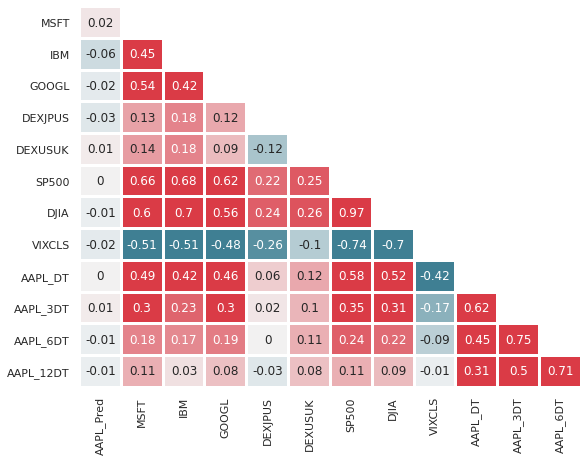

In [9]:
corrMat(df)

In [10]:
''' Draw a Bivariate Seaborn Pairgrid /w KDE density w/ '''
def snsPairGrid(df,title):

    ''' Plots a Seaborn Pairgrid w/ KDE & scatter plot of df features'''
    sns.set()
    g = sns.PairGrid(df,diag_sharey=False)
    g.fig.set_size_inches(14,14)
    g.map_diag(sns.kdeplot, lw=2)
    g.map_lower(sns.scatterplot,s=15,edgecolor="k",linewidth=1.0,alpha=0.4)
    g.map_lower(sns.kdeplot,cmap='plasma',n_levels=3)
    g.set(xlim=(-0.2,0.2),ylim=(-0.2,0.2))
    g.fig.suptitle(title, y=1.02)
    plt.tight_layout()
# Pairgr

In [11]:
# Pairgrid preparation
lst_stck.remove('AAPL')
lst_all = lst_stck + lst_curr + lst_indx
tlst1,tlst2 = splt_lst(lst_all) # create two similar size lists
tlst1.append('AAPL_Pred');tlst2.append('AAPL_Pred');lst_AAPL.append('AAPL_Pred')

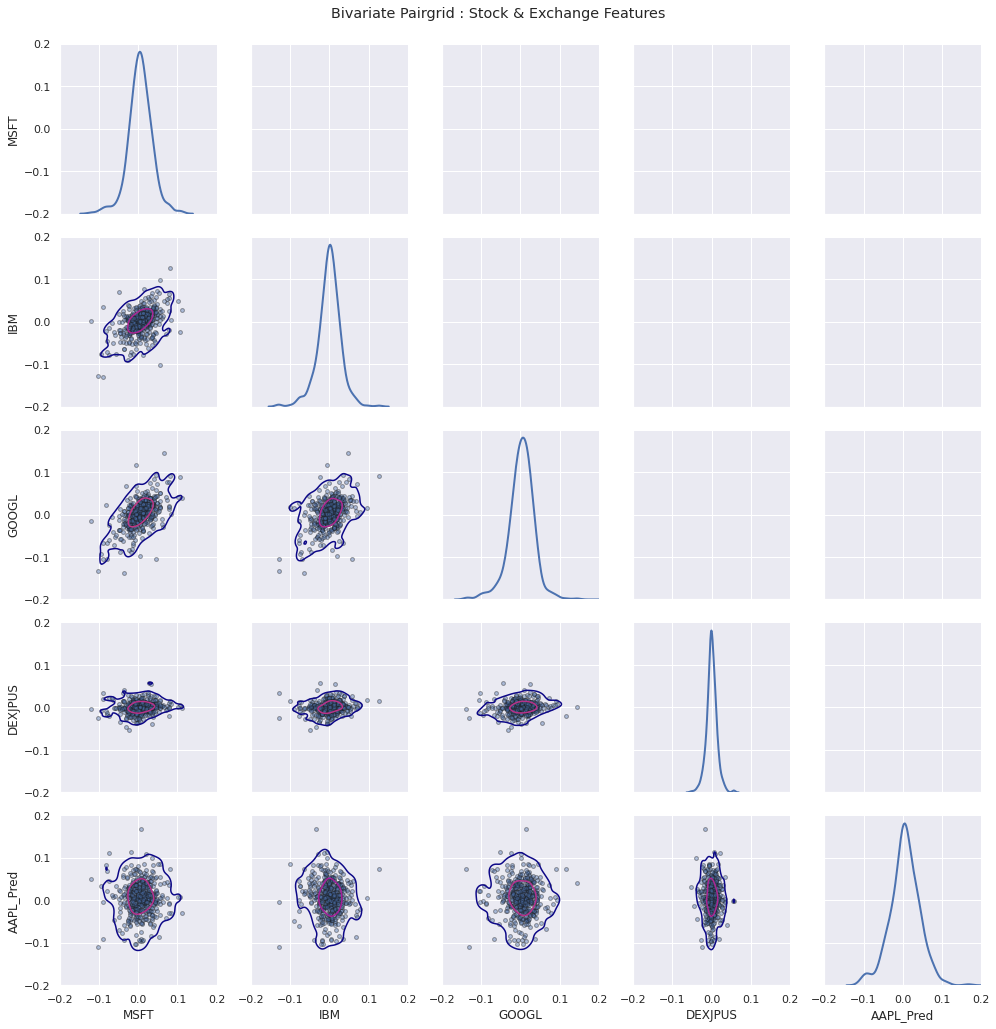

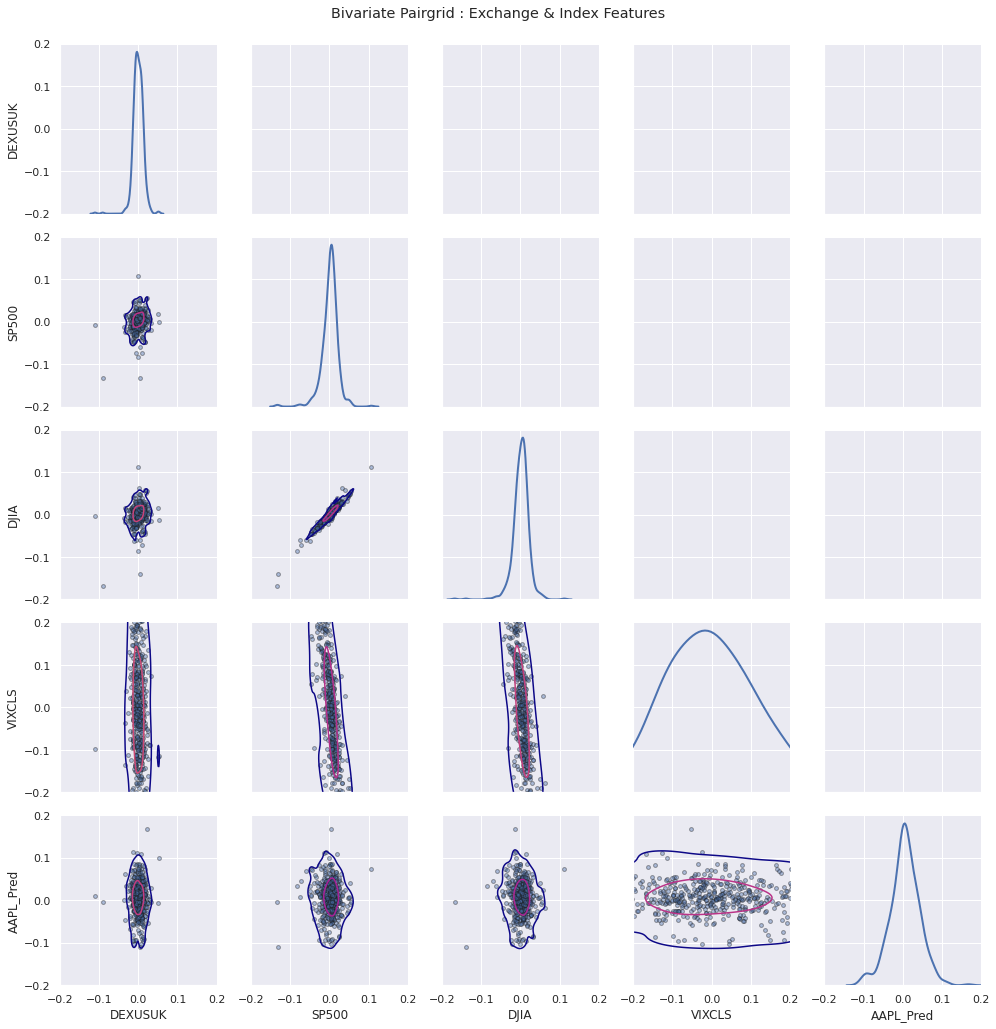

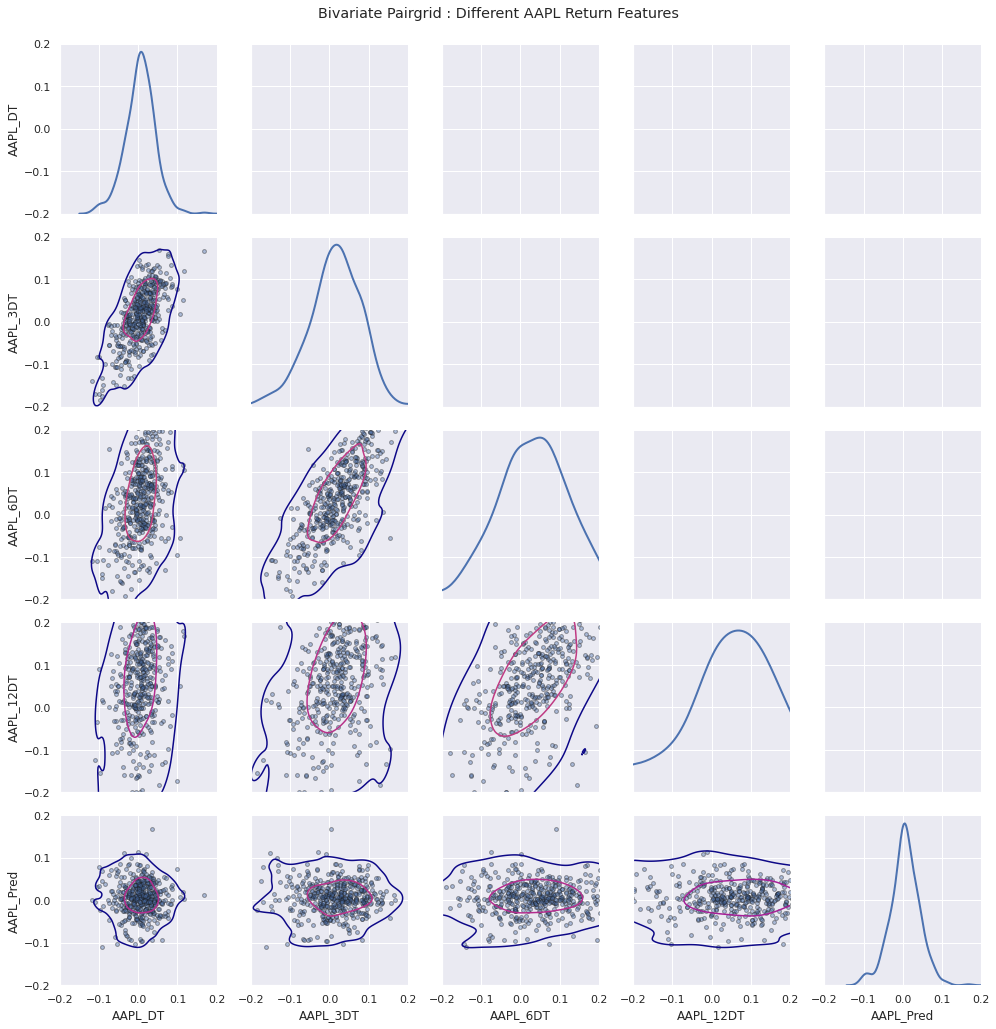

In [12]:
snsPairGrid(df[tlst1],'Bivariate Pairgrid : Stock & Exchange Features')
snsPairGrid(df[tlst2],'Bivariate Pairgrid : Exchange & Index Features')
snsPairGrid(df[lst_AAPL],'Bivariate Pairgrid : Different AAPL Return Features')

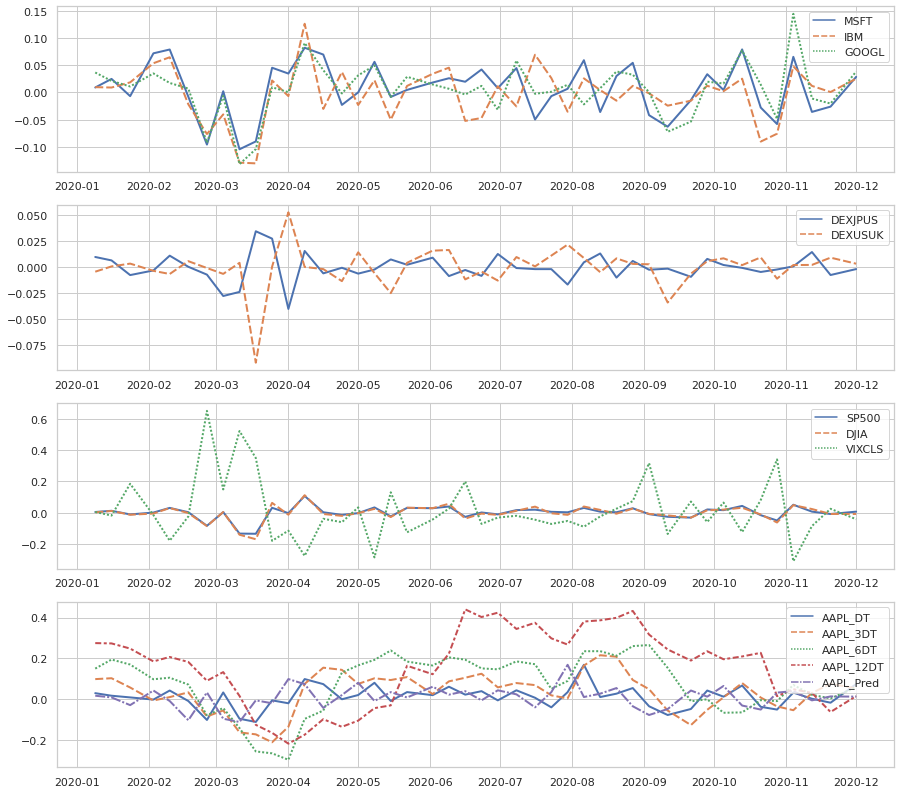

In [13]:
sns.set(style='whitegrid')
fig,ax = plt.subplots(4,1,figsize=(15,14))
sns.lineplot(data=df.loc['2020',lst_stck],lw=2,ax=ax[0])
sns.lineplot(data=df.loc['2020',lst_curr],lw=2,ax=ax[1])
sns.lineplot(data=df.loc['2020',lst_indx],lw=2,ax=ax[2])
sns.lineplot(data=df.loc['2020',lst_AAPL],lw=2,ax=ax[3])
plt.legend(loc='best')
plt.show()

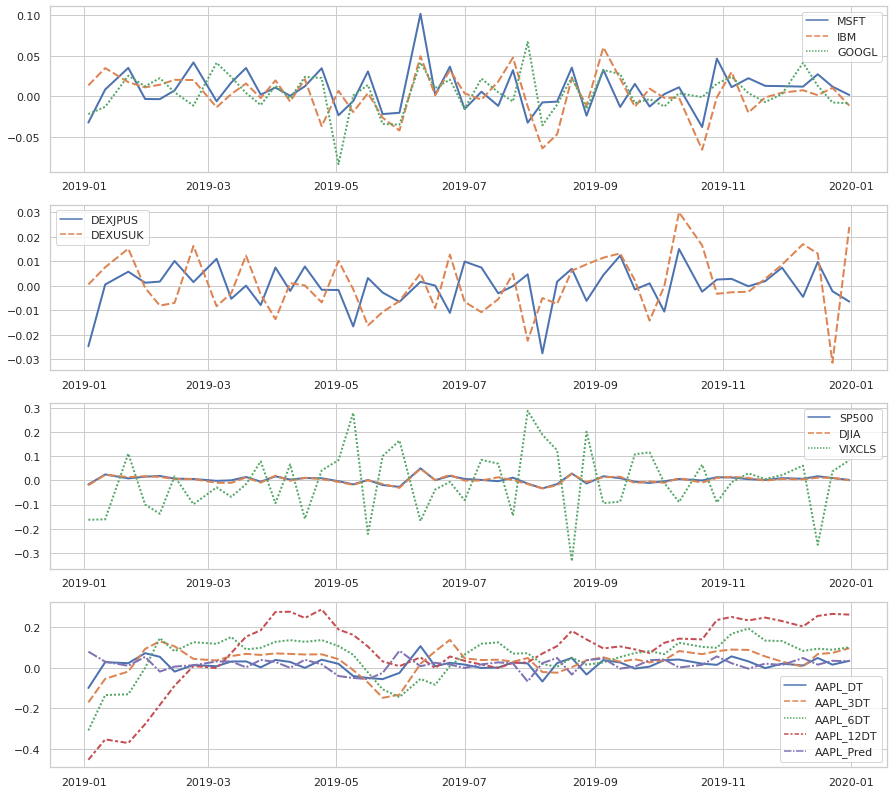

In [14]:
sns.set(style='whitegrid')
fig,ax = plt.subplots(4,1,figsize=(15,14))
sns.lineplot(data=df.loc['2019',lst_stck],lw=2,ax=ax[0])
sns.lineplot(data=df.loc['2019',lst_curr],lw=2,ax=ax[1])
sns.lineplot(data=df.loc['2019',lst_indx],lw=2,ax=ax[2])
sns.lineplot(data=df.loc['2019',lst_AAPL],lw=2,ax=ax[3])
plt.legend(loc='best')
plt.show()

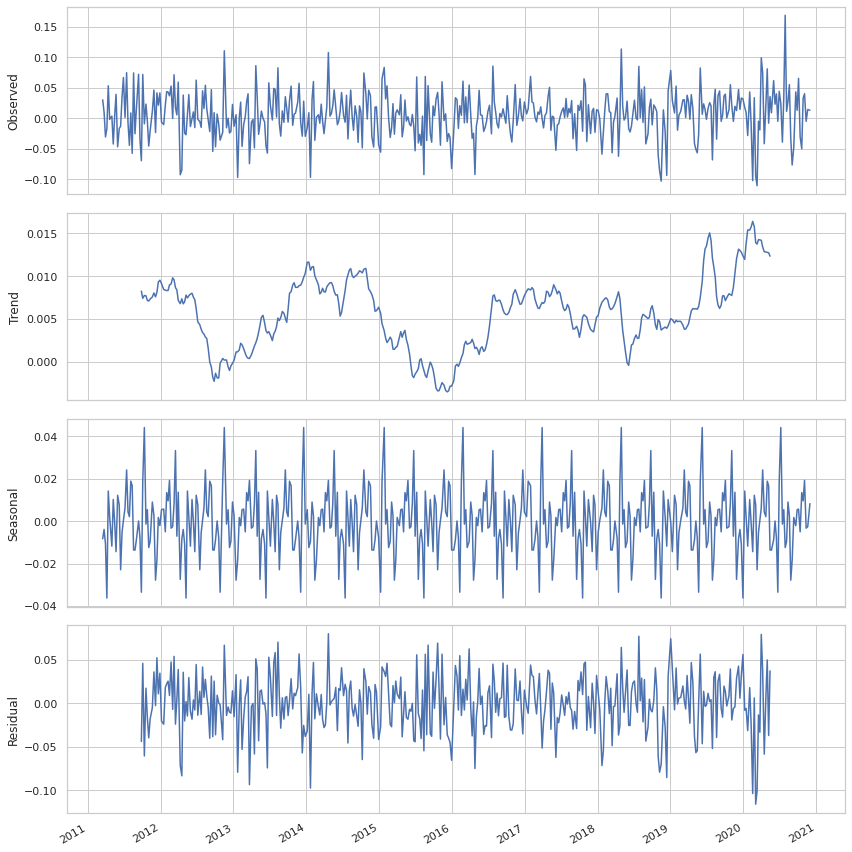

In [15]:
res = sm.tsa.seasonal_decompose(Y,freq=52)
fig = res.plot(); fig.set_figheight(12); fig.set_figwidth(12)
plt.tight_layout()

In [16]:
model = SelectKBest(k=5, score_func=f_regression)
fit = model.fit(X,Y)

df_score = pd.DataFrame(fit.scores_)
df_col = pd.DataFrame(X.columns)

score = pd.concat([df_col,df_score],axis=1)
score.columns = ['Specs','Score']  
score.nlargest(15,'Score').set_index('Specs').T 

Specs,IBM,DEXJPUS,VIXCLS,MSFT,GOOGL,AAPL_12DT,DJIA,AAPL_3DT,AAPL_6DT,DEXUSUK,SP500,AAPL_DT
Score,1.478,0.351,0.254,0.157,0.104,0.081,0.068,0.067,0.045,0.034,0.007,7.796e-04


In [17]:
model = RandomForestRegressor(200,random_state=0, n_jobs=-1)
fit = model.fit(X,Y);print(f'Model Score: {fit.score(X,Y)}')
df_score = pd.DataFrame(fit.feature_importances_)
df_col = pd.DataFrame(X.columns)
score = pd.concat([df_col,df_score],axis=1)
score.columns = ['Specs','Score']
score.nlargest(15,'Score').set_index('Specs')
display(score.T)

Model Score: 0.8410087504184707


,0,1,2,3,4,5,6,7,8,9,10,11
Specs,MSFT,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,AAPL_DT,AAPL_3DT,AAPL_6DT,AAPL_12DT
Score,0.0945,0.13,0.0892,0.083,0.089,0.0533,0.0654,0.0772,0.0752,0.0742,0.0867,0.0827


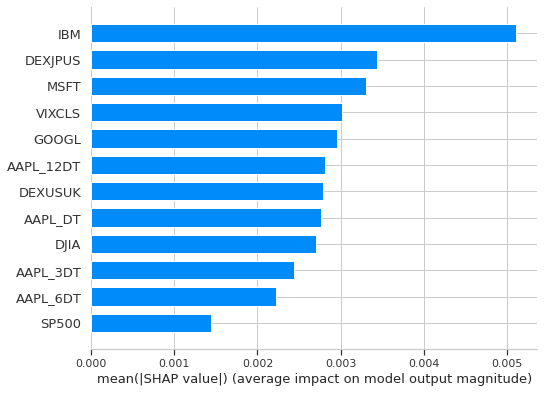

In [18]:
shap.initjs()
model = BlueCat(silent=True).fit(X,Y)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

In [19]:
val_size = 0.2
trdata_size = int(len(X)*(1-val_size))
X_train,X_test = X[0:trdata_size], X[trdata_size:len(X)]
y_train,y_test = Y[0:trdata_size], Y[trdata_size:len(X)]
train_all = pd.concat([X_train,y_train],axis=1)
test_all = pd.concat([X_test,y_test],axis=1)

In [20]:
from sklearn.base import BaseEstimator,RegressorMixin
class BLR(BaseEstimator,RegressorMixin):

    @staticmethod
    def posterior(X,y,alpha,beta):
    # Computes mean and covariance matrix of the posterior distribution
        S_N_inv = alpha * np.eye(X.shape[1]) + beta * X.T.dot(X)
        S_N = np.linalg.inv(S_N_inv)
        m_N = beta * S_N.dot(X.T).dot(y)
        return m_N, S_N, S_N_inv

    # instantiation values
    def __init__(self,alpha=1.0e-5,beta=1e-5,max_iter=300,rtol=1.0e-5,verbose=False,opt=True):    
        self.max_iter = max_iter # class contains only tunable hyperparameters (max convergence iteration)
        self.rtol = rtol       # convergence tolerance for hyperparameters
        self.alpha = alpha   # hyperparameter 
        self.beta = beta     # hyperparameter
        self.verbose = verbose # callouts y/n
        self.opt = opt        # optimisation y/n

    def fit(self,X,y):

        alpha_0 = 1e-5
        beta_0 = 1e-5
        N, M = X.shape
        eigenvalues_0 = np.linalg.eigvalsh(X.T.dot(X))

        self.beta = beta_0
        self.alpha = alpha_0

        # Hyperparameter tuning using implicit objective function parameters:
        # Maximization of the log marginal likelihood wrt/ alpha,beta
        if(self.opt is True):
        
            for i in range(self.max_iter):

                if(type(X) is np.ndarray):
                    self.X = X;self.y = y
                else:
                    self.X = X.values; self.y = y.values

                beta_prev = self.beta
                alpha_prev = self.alpha
                eigenvalues = eigenvalues_0 * self.beta

                self.m_N, self.S_N, self.S_N_inv = self. posterior(X,y, self.alpha, self.beta)

                gamma = np.sum(eigenvalues / (eigenvalues + self.alpha))
                self.alpha = gamma / np.sum(self.m_N ** 2)
                beta_inv = 1.0 / (N - gamma) * np.sum((y - X.dot(self.m_N)) ** 2)
                self.beta = 1.0 / beta_inv

                if np.isclose(alpha_prev,self.alpha,rtol=self.rtol) and np.isclose(beta_prev, self.beta, rtol=self.rtol):
                    if self.verbose:
                        print(f'Convergence after {i + 1} iterations.')
                        print(self.alpha, self.beta)
                    break

                if (i is self.max_iter):
                    print(f'Stopped after {self.max_iter} iterations.')
                    print(self.alpha, self.beta)
            
            # Self-defined Hyperparameters
            else:
                print(f'Self-defined hyperparameters: {self.alpha} & {self.beta}')
                self.m_N, self.S_N, self.S_N_inv = self. posterior(X,y, self.alpha, self.beta)
                
        return self # return one of the two, simplified variant doesn't always work well

    ''' Posterior-Prediction  '''
    # Requires valid self.m_N, self.beta, self.S_N ( from train)
    # local Feature Matrix X required as input
    def predict(self,X):
        self.mu_s = X.dot(self.m_N)
        self.cov_s = 1.0 / self.beta + np.sum(X.dot(self.S_N) * X, axis=1)
        return self.mu_s

In [20]:
val_size = 0.2
trdata_size = int(len(X)*(1-val_size))
X_train,X_test = X[0:trdata_size], X[trdata_size:len(X)]
y_train,y_test = Y[0:trdata_size], Y[trdata_size:len(X)]
train_all = pd.concat([X_train,y_train],axis=1)
test_all = pd.concat([X_test,y_test],axis=1)

In [21]:
from sklearn.base import BaseEstimator,RegressorMixin
class BLR(BaseEstimator,RegressorMixin):

    @staticmethod
    def posterior(X,y,alpha,beta):
    # Computes mean and covariance matrix of the posterior distribution
        S_N_inv = alpha * np.eye(X.shape[1]) + beta * X.T.dot(X)
        S_N = np.linalg.inv(S_N_inv)
        m_N = beta * S_N.dot(X.T).dot(y)
        return m_N, S_N, S_N_inv

    # instantiation values
    def __init__(self,alpha=1.0e-5,beta=1e-5,max_iter=300,rtol=1.0e-5,verbose=False,opt=True):    
        self.max_iter = max_iter # class contains only tunable hyperparameters (max convergence iteration)
        self.rtol = rtol       # convergence tolerance for hyperparameters
        self.alpha = alpha   # hyperparameter 
        self.beta = beta     # hyperparameter
        self.verbose = verbose # callouts y/n
        self.opt = opt        # optimisation y/n

    def fit(self,X,y):

        alpha_0 = 1e-5
        beta_0 = 1e-5
        N, M = X.shape
        eigenvalues_0 = np.linalg.eigvalsh(X.T.dot(X))

        self.beta = beta_0
        self.alpha = alpha_0

        # Hyperparameter tuning using implicit objective function parameters:
        # Maximization of the log marginal likelihood wrt/ alpha,beta
        if(self.opt is True):
        
            for i in range(self.max_iter):

                if(type(X) is np.ndarray):
                    self.X = X;self.y = y
                else:
                    self.X = X.values; self.y = y.values

                beta_prev = self.beta
                alpha_prev = self.alpha
                eigenvalues = eigenvalues_0 * self.beta

                self.m_N, self.S_N, self.S_N_inv = self. posterior(X,y, self.alpha, self.beta)

                gamma = np.sum(eigenvalues / (eigenvalues + self.alpha))
                self.alpha = gamma / np.sum(self.m_N ** 2)
                beta_inv = 1.0 / (N - gamma) * np.sum((y - X.dot(self.m_N)) ** 2)
                self.beta = 1.0 / beta_inv

                if np.isclose(alpha_prev,self.alpha,rtol=self.rtol) and np.isclose(beta_prev, self.beta, rtol=self.rtol):
                    if self.verbose:
                        print(f'Convergence after {i + 1} iterations.')
                        print(self.alpha, self.beta)
                    break

                if (i is self.max_iter):
                    print(f'Stopped after {self.max_iter} iterations.')
                    print(self.alpha, self.beta)
            
            # Self-defined Hyperparameters
            else:
                print(f'Self-defined hyperparameters: {self.alpha} & {self.beta}')
                self.m_N, self.S_N, self.S_N_inv = self. posterior(X,y, self.alpha, self.beta)
                
        return self # return one of the two, simplified variant doesn't always work well

    ''' Posterior-Prediction  '''
    # Requires valid self.m_N, self.beta, self.S_N ( from train)
    # local Feature Matrix X required as input
    def predict(self,X):
        self.mu_s = X.dot(self.m_N)
        self.cov_s = 1.0 / self.beta + np.sum(X.dot(self.S_N) * X, axis=1)
        return self.mu_s

In [22]:
from sklearn.base import BaseEstimator,RegressorMixin
from numpy.linalg import cholesky, det, lstsq, inv, eigvalsh, pinv
from scipy.optimize import minimize
pi = 4.0*np.arctan(1.0)

# Usage similar to any sklearn model
class GPR(BaseEstimator,RegressorMixin):

    ''' Class Instantiation Related Variables '''
    # With just the one class specific GPC.kernel
    def __init__(self,kernel='rbf',theta=10.0,sigma=10.0,sigma_n=0.01,opt=True):
        self.theta = theta            # Hyperparameter associated with covariance function
        self.sigma = sigma            #                       ''
        self.sigma_n = sigma_n        # Hyperparameter associated with cov.mat's diagonal component
        self.opt = opt                # Update hyperparameters with objective function optimisation
        GPR.kernel = kernel           # Selection of Covariance Function, class specific instantiation

    ''' local covariance functions '''
    # Covariance Functions represent a form of weight adjustor in the matrix W/K
    # for each of the combinations present in the feature matrix
    @staticmethod
    def covfn(X0,X1,theta=1.0,sigma=1.0):

        ''' Radial Basis Covariance Function '''
        if(GPR.kernel == 'rbf'):
            r = np.sum(X0**2,1).reshape(-1,1) + np.sum(X1**2,1) - 2 * np.dot(X0,X1.T)
            return sigma**2 * np.exp(-0.5/theta**2*r)

        ''' Matern Covariance Class of Funtions '''
        if(GPR.kernel == 'matern'):
            lid=1
            r = np.sum(X0**2,1)[:,None] + np.sum(X1**2,1) - 2 * np.dot(X0,X1.T)
            if(lid==1):
                return sigma**2 * np.exp(-r/theta)
            elif(lid==2):
                ratio = r/theta
                v1 = (1.0+np.sqrt(3)*ratio)
                v2 = np.exp(-np.sqrt(3)*ratio)
                return sigma**2*v1*v2
            elif(lid==3):
                ratio = r/theta
                v1 = (1.0+np.sqrt(5)*ratio+(5.0/3.0)*ratio**2)
                v2 = np.exp(-np.sqrt(5)*ratio)
                return sigma**2*v1*v2
        else:
            print('Covariance Function not defined')
    
    ''' Train the GPR Model'''
    def fit(self,X,y):
        
        # Two Parts Associated with base GP Model:
        # - Hyperaparemeter; theta, sigma, sigma_n selection
        # - Definition of Training Covariance Matrix
        # Both are recalled in Posterior Prediction, predict()
        
        ''' Working w/ numpy matrices'''
        if(type(X) is np.ndarray):
            self.X = X;self.y = y
        else:
            self.X = X.values; self.y = y.values
        self.ntot,ndim = self.X.shape

        ''' Optimisation Objective Function '''
        # Optimisation of hyperparameters via the objective funciton
        def llhobj(X,y,noise):
            
            # Simplified Variant
            def llh_dir(hypers):
                K = self.covfn(X,X,theta=hypers[0],sigma=hypers[1]) + noise**2 * np.eye(self.ntot)
                return 0.5 * np.log(det(K)) + \
                    0.5 * y.T.dot(inv(K).dot(y)).ravel()[0] + 0.5 * len(X) * np.log(2*pi)

            # Full Likelihood Equation
            def nll_full(hypers):
                K = self.covfn(X,X,theta=hypers[0],sigma=hypers[1]) + noise**2 * np.eye(self.ntot)
                L = cholesky(K)
                return np.sum(np.log(np.diagonal(L))) + \
                    0.5 * y.T.dot(lstsq(L.T, lstsq(L,y)[0])[0]) + \
                    0.5 * len(X) * np.log(2*pi)

            return nll_full # return one of the two, simplified variant doesn't always work well

        ''' Update hyperparameters based on set objective function '''
        if(self.opt==True):
            # define the objective funciton
            objfn = llhobj(self.X,self.y,self.sigma_n)
            # search for the optimal hyperparameters based on given relation
            res = minimize(objfn,[1,1],bounds=((1e-5,None),(1e-5, None)),method='L-BFGS-B')
            self.theta,self.sigma = res.x # update the hyperparameters to 

        ''' Get Training Covariance Matrix, K^-1 '''
        Kmat = self.covfn(self.X,self.X,self.theta,self.sigma) \
                 + self.sigma_n**2 * np.eye(self.ntot) # Covariance Matrix (Train/Train)
        self.IKmat = pinv(Kmat) # Pseudo Matrix Inversion (More Stable)
        return self  # return class & use w/ predict()

    ''' Posterior Prediction;  '''
    # Make a prediction based on what the model has learned 
    def predict(self,Xm):
        
        # Covariance Matrices x2 required; (Train/Train,Train/Test)
        mtot = Xm.shape[0]  # Number of Test Matrix Instances 
        K_s = self.covfn(self.X,Xm,self.theta,self.sigma)  # Covariance Matrix (Train/Test) 
        self.mu_s = K_s.T.dot(self.IKmat).dot(self.y)      # Posterior Mean Prediction
        return self.mu_s # return posterior mean
# Sample Usage:
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error as mse

def modelEval(ldf,feature='target'):

    # Given a dataframe, split feature/target variable
    X = ldf.copy();  y = ldf[feature].copy(); del X[feature]
    X = X.values; y = y.values

    # model evaluation
    model = GPR().fit(X,y)
    score = mse(y,model.predict(X));print(f'RMS:{score}')    
    model2 = BLR().fit(X,y)
    score = mse(y,model2.predict(X));print(f'RMS:{score}')
    
boston = load_boston()
X = boston.data
y = boston.target
df_X = pd.DataFrame(X,columns=boston.feature_names)
df_X['target'] = pd.Series(y)
modelEval(df_X)

RMS:1.0896284972953787e-08
RMS:24.21982856710371


In [23]:
''' Draw a single Heatmap using Seaborn '''
def heatmap1(values,xlabel,ylabel,xticklabels,yticklabels,
             cmap='plasma',vmin=None,vmax=None,fmt="%0.2f",title=None):

    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(values, ax=ax,cmap=cmap,cbar=True)
    
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel);ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + 0.5)
    ax.set_yticks(np.arange(len(yticklabels)) + 0.5)
    ax.set_xticklabels(xticklabels);ax.set_yticklabels(yticklabels)
    ax.set_title(title)
    ax.set_aspect(1)
    
    for p, color, value in zip(img.get_paths(), img.get_facecolors(),img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")

In [24]:
models = []
models.append(('GPR',GPR()))                        # Gaussian Process Regression
models.append(('LR',LinearRegression()))            # Linear Model
models.append(('LASSO',Lasso()))                    # Linear Model
models.append(('EN',ElasticNet()))                  # Linear Model 
models.append(('KNN',KNeighborsRegressor()))        # kNN unsupervised method
models.append(('CART',DecisionTreeRegressor()))     # Tree Based Model
models.append(('SVR',SVR()))                        # Support Vector Regresso
models.append(('MLP',MLPRegressor()))               # Feed forward Neural Network
models.append(('ABR',AdaBoostRegressor()))          # Boosting Method
models.append(('GBR',GradientBoostingRegressor()))  # Boosting Method
models.append(('RFR',RandomForestRegressor()))      # Bagging Methods
models.append(('ETR',ExtraTreesRegressor()))        # Bagging Methods